#### Goal

The goal of this challenge is to build a model that predicts conversion rate and, based on the
model, come up with ideas to improve revenue.

---------
#### Challenge Description

Your project is to:
- Predict conversion rate
- Come up with recommendations for the product team and the marketing team to improve conversion rate


資料集說明
- country : user country based on the IP address
- age : user age. 
- new_user : whether the user created the account during this session or had already an account and simply came back to the site
- source : marketing channel source
   - Ads: came to the site by clicking on an advertisement
   - Seo: came to the site by clicking on search results
   - Direct: came to the site by directly typing the URL on the browser
- total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
- converted: this is our label. 1 means they converted within the session, 0 means they left
without buying anything. The company goal is to increase conversion rate: # conversions
/ total sessions.





In [1]:

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import copy
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
import warnings
from IPython.display import display
from sklearn.model_selection import train_test_split, KFold, GridSearchCV ,cross_val_score

from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score ,classification_report
from sklearn.metrics import roc_curve , auc, f1_score , recall_score , precision_score
warnings.filterwarnings('ignore')


C:\Users\user\Anaconda3\envs\ml_test\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\Anaconda3\envs\ml_test\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\user\Anaconda3\envs\ml_test\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
df = pd.read_csv('./data/conversion_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [3]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
## 描述性統計 
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
## 確認 DataFrame的  .dtypes(欄位類型), .columns(欄位名稱) 
numeric_columns = []
object_columns = []


for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        numeric_columns.append(feature)
    else:
        object_columns.append(feature)


print(f'{len(numeric_columns)} df Number Features : {numeric_columns}\n')
print(f'{len(object_columns)} df Object Features : {object_columns}\n')

4 df Number Features : ['age', 'new_user', 'total_pages_visited', 'converted']

2 df Object Features : ['country', 'source']



In [6]:
## 看各欄位的元素
print('特徵', '         ', '去重複後的計算量','   ', '內容')
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:6])

特徵           去重複後的計算量     內容
country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21, 22]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5, 6]
converted                2	 [0, 1]


In [7]:
## converted 的個別出現次數
df.loc[:,'converted'].value_counts()

0    306000
1     10200
Name: converted, dtype: int64

### 從描述性統計
1.可以看到age的最大值是123,明顯跟現實有點出入

2.整體用戶年紀很年輕

3.轉換率= 完成轉換次數/訪客數量*100% = 10200/306000 *100% = 3.33%

------
###### 轉換率補充知識: https://reurl.cc/ymmvza

### 處理異常值

In [8]:
## 各個 age 的出現次數
df.groupby('age')['age'].count()

age
17      7597
18      8466
19      9349
20     10156
21     10966
22     11701
23     12336
24     12960
25     13460
26     13931
27     14084
28     14341
29     14158
30     14346
31     13692
32     13507
33     12631
34     12108
35     11471
36     10779
37      9761
38      8970
39      8202
40      7148
41      6401
42      5588
43      4904
44      4224
45      3634
46      2994
47      2504
48      2121
49      1629
50      1356
51      1093
52       935
53       627
54       520
55       394
56       286
57       247
58       165
59       127
60        94
61        71
62        59
63        35
64        27
65        15
66         9
67         5
68         5
69         3
70         2
72         1
73         1
77         1
79         1
111        1
123        1
Name: age, dtype: int64

In [9]:
## age<100 描述性統計 
df_under100 = df[df['age'] <100]
df_under100.describe()


,age,new_user,total_pages_visited,converted
count,316198.000000,316198.000000,316198.000000,316198.000000
mean,30.569311,0.685469,4.872918,0.032252
std,8.268958,0.464329,3.341053,0.176669
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


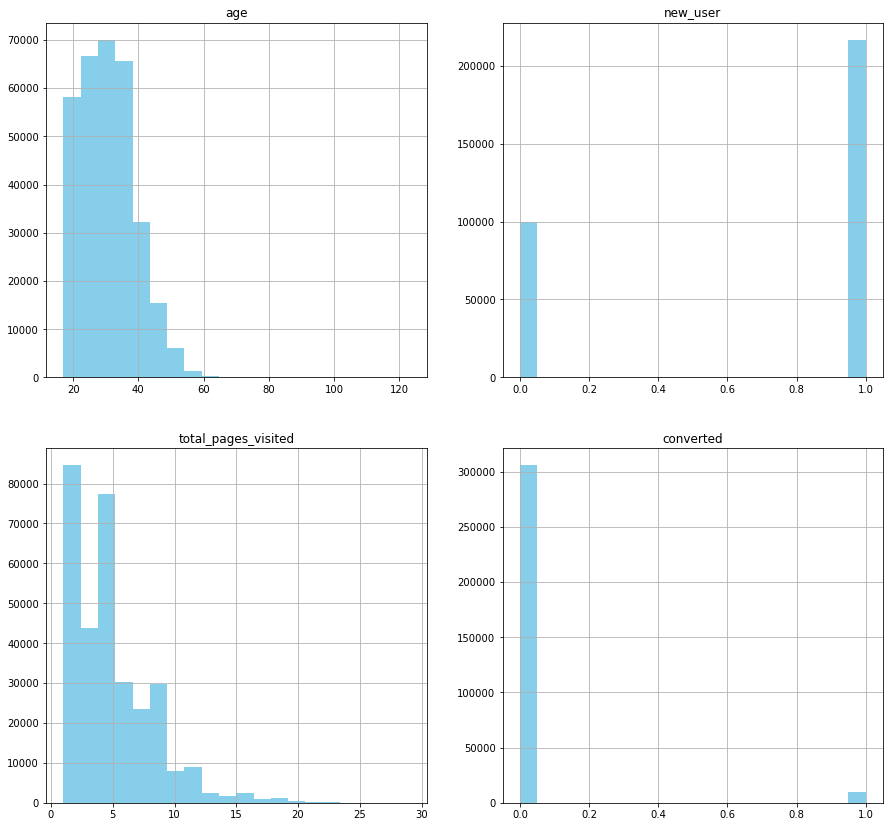

In [10]:
## 將訓練資料集的每個特徵值畫出直方圖看資料分布  x軸出現次數  y軸是數據
fig_cols = 2
fig_rows = len(numeric_columns)

plt.figure(figsize=(15,30))
for i,col in enumerate (numeric_columns):
    plt.subplot(fig_rows,fig_cols,i+1)
    df[col].hist( color = "skyblue",bins=20)
    plt.title(str(col))
plt.show()

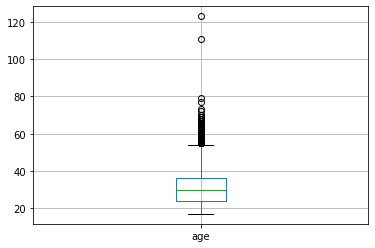

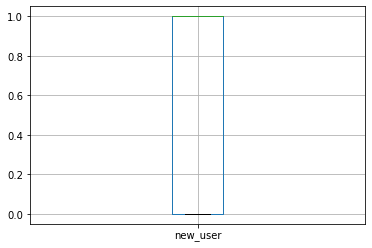

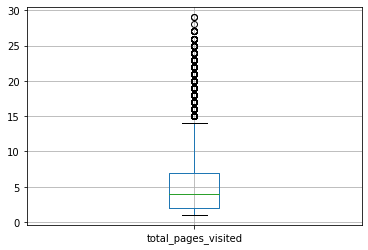

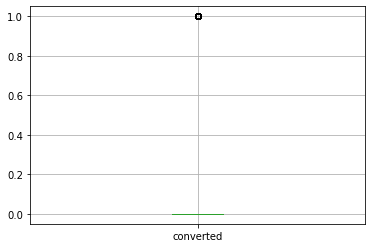

In [11]:
## 逐筆畫出盒形圖

for col in numeric_columns:
    #print(col)
    df.boxplot(column = str(col))
    plt.show()

### 查看數值型欄位相關係數

<function matplotlib.pyplot.show(*args, **kw)>

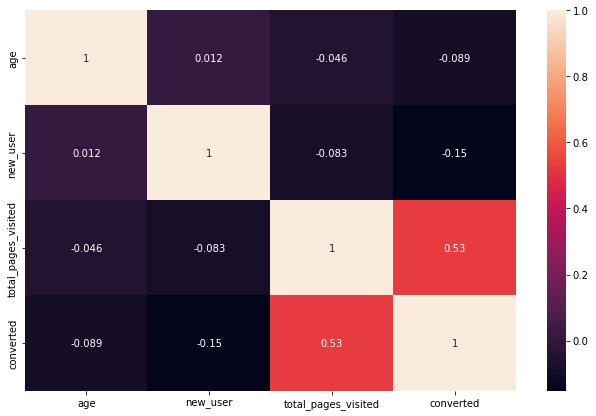

In [12]:
plt.figure(figsize=(11,7))
sns.heatmap(df.corr(),annot=True)
plt.show

偏態(Skewness): 0.52, 峰度(Kurtosis): -0.03


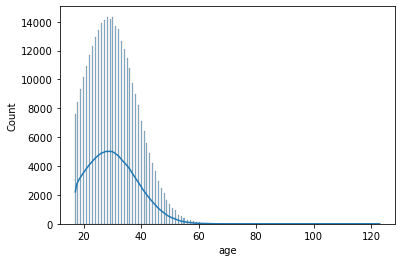

In [13]:
## 看age欄位的skewness 與 kurtosis
skewness = round(df['age'].skew(), 2)
kurtosis = round(df['age'].kurt(), 2)
print(f"偏態(Skewness): {skewness}, 峰度(Kurtosis): {kurtosis}")

## 繪製分布圖
sns.histplot(df['age'], kde=True)
plt.show()

取log調整後偏態(Skewness): -0.04, 取log調整後峰度(Kurtosis): -0.65


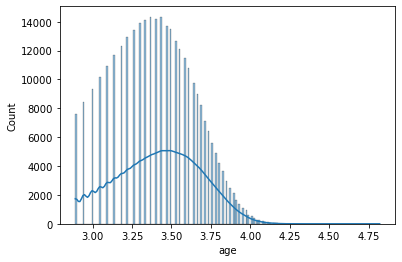

count    316200.000000
mean          3.418070
std           0.262247
min           2.890372
25%           3.218876
50%           3.433987
75%           3.610918
max           4.820282
Name: age, dtype: float64

In [14]:
## 針對 age欄位做 對數轉換 (注意:資料不能有0或負數) 
log1p_data = np.log1p(df['age'])
# skewness 與 kurtosis
skewness = round(log1p_data.skew(), 2)
kurtosis = round(log1p_data.kurt(), 2)
print(f"取log調整後偏態(Skewness): {skewness}, 取log調整後峰度(Kurtosis): {kurtosis}")

# 繪製分布圖
sns.histplot(log1p_data, kde=True)
plt.show()
log1p_data.describe()

平方根轉換後偏態(Skewness): 0.22, 平方根轉換後峰度(Kurtosis): -0.49


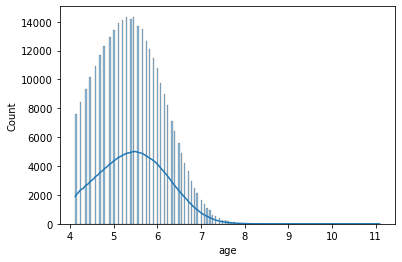

count    316200.000000
mean          5.479064
std           0.741430
min           4.123106
25%           4.898979
50%           5.477226
75%           6.000000
max          11.090537
Name: age, dtype: float64

In [15]:
## 針對 age欄位做 平方根轉換  (注意:資料不能有負數) 
sqrt_data = (df['age'])**(1/2)
# skewness 與 kurtosis
skewness = round(sqrt_data.skew(), 2)
kurtosis = round(sqrt_data.kurt(), 2)
print(f"平方根轉換後偏態(Skewness): {skewness}, 平方根轉換後峰度(Kurtosis): {kurtosis}")

# 繪製分布圖
sns.histplot(sqrt_data, kde=True)
plt.show()
sqrt_data.describe()

In [16]:
## 透過boxplot 將所有特徵超出1.5倍IQR的概念將這些Outlier排除
print ("Shape Of The Before Ouliers: ",df['age'].shape)
n=1.5
#IQR = Q3-Q1
IQR = np.percentile(df['age'],75) - np.percentile(df['age'],25)
# outlier = Q3 + n*IQR 
transform_data = df[df['age']< np.percentile(df['age'],75)+n*IQR]
# outlier = Q1 - n*IQR 
transform_data = transform_data[transform_data['age'] > np.percentile(transform_data['age'],25)-n*IQR]['age']
print ("Shape Of The After Ouliers: ",transform_data.shape)

## 會排除掉2070筆資料

Shape Of The Before Ouliers:  (316200,)
Shape Of The After Ouliers:  (314130,)


偏態(Skewness): 0.39, 峰度(Kurtosis): -0.48


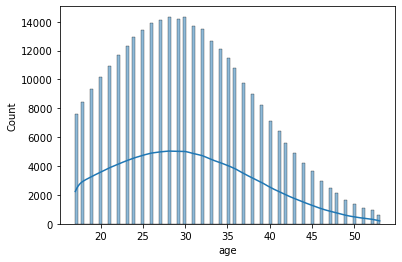

In [17]:
## 看age欄位的skewness 與 kurtosis
skewness = round(transform_data.skew(), 2)
kurtosis = round(transform_data.kurt(), 2)
print(f"偏態(Skewness): {skewness}, 峰度(Kurtosis): {kurtosis}")

## 繪製分布圖
sns.histplot(transform_data, kde=True)
plt.show()

In [18]:
transform_data.describe()

count    314130.000000
mean         30.396947
std           8.014096
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max          53.000000
Name: age, dtype: float64

### 先測試看看用boxplot 排除離群值的age對模型的影響

In [19]:
#df_clean_age =  df[(df['age'] <= 90)] 
df_clean_age =  df[(df['age'] <= 53)] 

In [20]:
## converted 的個別出現次數
df_clean_age.loc[:,'converted'].value_counts()

0    303941
1     10189
Name: converted, dtype: int64

偏態(Skewness): 0.39, 峰度(Kurtosis): -0.48


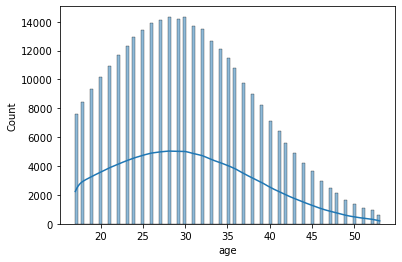

In [21]:
## 看age欄位的skewness 與 kurtosis
skewness = round(df_clean_age ['age'].skew(), 2)
kurtosis = round(df_clean_age ['age'].kurt(), 2)
print(f"偏態(Skewness): {skewness}, 峰度(Kurtosis): {kurtosis}")

## 繪製分布圖
sns.histplot(df_clean_age ['age'], kde=True)
plt.show()

## 探索性數據分析

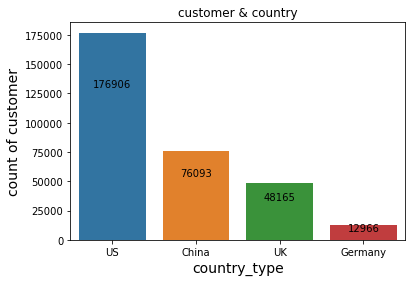

In [22]:
country_type = df_clean_age['country'].value_counts()

fig, ax = plt.subplots(figsize=(6, 4))

x_axis = country_type.index.tolist()
y_axis = country_type.values.tolist()

g = sns.barplot(x = x_axis, y = y_axis)

plt.title('customer & country')
plt.ylabel('count of customer', fontsize = 14)
plt.xlabel('country_type', fontsize = 14)
for p in g.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h*0.75)
    s = f'{h:0.0f}'
    ax.annotate(s=s , xy=xy , ha='center', va='center')

plt.show()

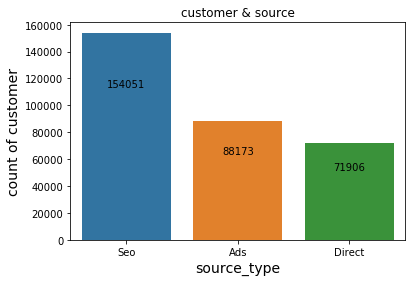

In [23]:
source_type = df_clean_age['source'].value_counts()

fig, ax = plt.subplots(figsize=(6, 4))

x_axis = source_type.index.tolist()
y_axis = source_type.values.tolist()

g = sns.barplot(x = x_axis, y = y_axis)


plt.title('customer & source')
plt.ylabel('count of customer', fontsize = 14)
plt.xlabel('source_type', fontsize = 14)
for p in g.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h*0.75)
    s = f'{h:0.0f}'
    ax.annotate(s=s, xy=xy, ha='center', va='center')

plt.show()
## 流量  SEO > ADS >Direct

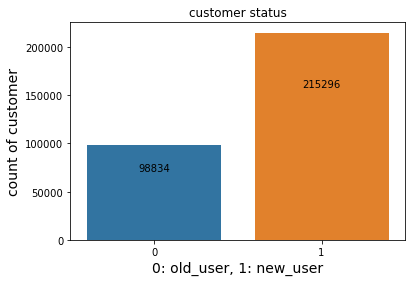

In [24]:
customer_type = df_clean_age['new_user'].value_counts()

fig, ax = plt.subplots(figsize=(6, 4))

x_axis = customer_type.index.tolist()
y_axis = customer_type.values.tolist()

g = sns.barplot(x = x_axis, y = y_axis)


plt.title('customer status')
plt.ylabel('count of customer', fontsize = 14)
plt.xlabel('0: old_user, 1: new_user', fontsize = 14)
for p in g.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h*0.75)
    s = f'{h:0.0f}'
    ax.annotate(s=s, xy=xy, ha='center', va='center')

plt.show()
## 新客數 > 舊客數

### Country 與轉換的關係

In [25]:
## 不同國家的轉換率   ## cr=  convert_rate

grouped_country = df_clean_age.groupby(['country', 'converted']).size().reset_index()
grouped_country.columns = ['country', 'converted', 'count']

grouped_country

,country,converted,count
0,China,0,75991
1,China,1,102
2,Germany,0,12151
3,Germany,1,815
4,UK,0,45618
5,UK,1,2547
6,US,0,170181
7,US,1,6725


In [26]:
grouped_cr_country = df_clean_age[['country', 'converted']].groupby('country').mean().reset_index()
grouped_cr_country.columns = ['country', 'convert_rate']
grouped_cr_country.head()


,country,convert_rate
0,China,0.001340
1,Germany,0.062857
2,UK,0.052881
3,US,0.038015


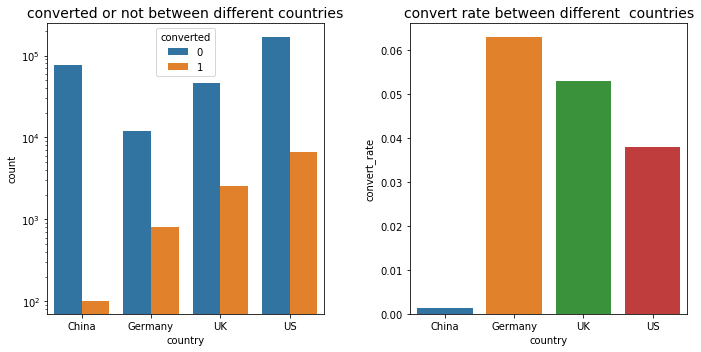

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.barplot(data = grouped_country, x ='country', hue='converted', y = 'count', ax = ax[0])
ax[0].set_yscale("log")
ax[0].set_title('converted or not between different countries', fontsize=14)

sns.barplot(data = grouped_cr_country, x ='country', y = 'convert_rate', ax = ax[1])
ax[1].set_title('convert rate between different  countries', fontsize=14)
plt.tight_layout()
plt.show()

### Age與轉換的關係

In [28]:
## 各年紀的轉換率  ## cr=  convert_rate

grouped_age = df_clean_age.groupby(['age', 'converted']).size().reset_index()
grouped_age.columns = ['age', 'converted', 'count']

grouped_cr_age = df_clean_age[['age', 'converted']].groupby('age').mean().reset_index()
grouped_cr_age.columns = ['age', 'convert_rate']

grouped_cr_age.head()



,age,convert_rate
0,17,0.071607
1,18,0.066029
2,19,0.058616
3,20,0.057109
4,21,0.053985


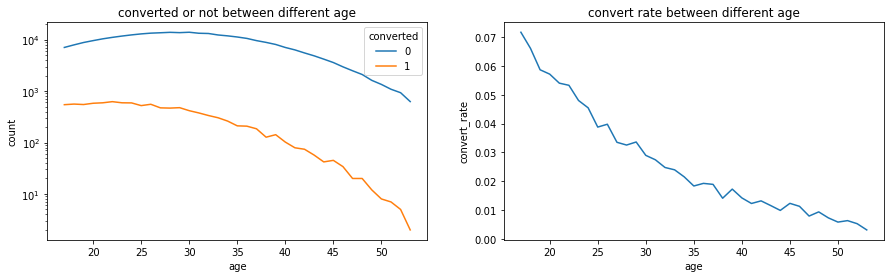

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex = True)

sns.lineplot(data = grouped_age, x ='age', hue='converted', y = 'count', ax = ax[0])
ax[0].set_yscale("log")
ax[0].set_title('converted or not between different age')

sns.lineplot(data = grouped_cr_age, x ='age', y = 'convert_rate', ax = ax[1])
ax[1].set_title('convert rate between different age')

plt.show()

### New_user與轉換的關係

In [30]:
## 新舊用戶的轉換率

grouped_user = df_clean_age.groupby(['new_user', 'converted']).size().reset_index()
grouped_user.columns = ['new_user', 'converted', 'count']

grouped_cr_user = df_clean_age[['new_user', 'converted']].groupby('new_user').mean().reset_index()
grouped_cr_user.columns = ['new_user', 'convert_rate']
grouped_cr_user.head()

,new_user,convert_rate
0,0,0.072384
1,1,0.014097


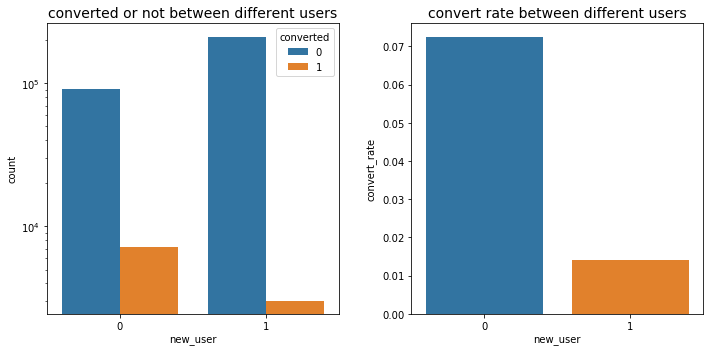

In [31]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.barplot(data = grouped_user, x ='new_user', hue='converted', y = 'count', ax = ax[0])
ax[0].set_yscale("log")
ax[0].set_title('converted or not between different users', fontsize=14)

sns.barplot(data = grouped_cr_user , x ='new_user', y = 'convert_rate', ax = ax[1])
ax[1].set_title('convert rate between different users', fontsize=14)
plt.tight_layout()
plt.show()

### Source與轉換的關係

In [32]:
## Source的轉換率

grouped_source = df_clean_age.groupby(['source', 'converted']).size().reset_index()
grouped_source.columns = ['source', 'converted', 'count']

grouped_cr_source = df_clean_age[['source', 'converted']].groupby('source').mean().reset_index()
grouped_cr_source.columns = ['source', 'convert_rate']
grouped_cr_source.head()

,source,convert_rate
0,Ads,0.034682
1,Direct,0.028370
2,Seo,0.033047


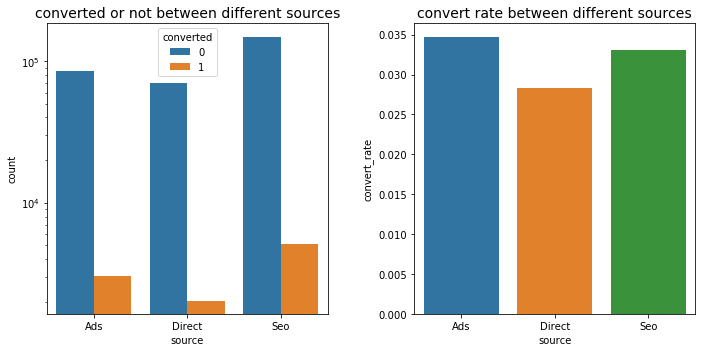

In [33]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.barplot(data = grouped_source , x='source' , hue='converted', y = 'count', ax = ax[0])
ax[0].set_yscale("log")
ax[0].set_title('converted or not between different sources', fontsize=14)

sns.barplot(data = grouped_cr_source  , x ='source', y = 'convert_rate', ax = ax[1])
ax[1].set_title('convert rate between different sources', fontsize=14)
plt.tight_layout()
plt.show()

### Total_pages_visited與轉換的關係

In [34]:
## total_pages_visited的轉換率

grouped_pages = df_clean_age.groupby(['total_pages_visited', 'converted']).size().reset_index()
grouped_pages.columns = ['total_pages_visited', 'converted', 'count']

grouped_cr_pages = df_clean_age[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
grouped_cr_pages.columns = ['total_pages_visited', 'convert_rate']
grouped_cr_pages.head()

,total_pages_visited,convert_rate
0,1,0.000000
1,2,0.000229
2,3,0.000253
3,4,0.000785
4,5,0.001580


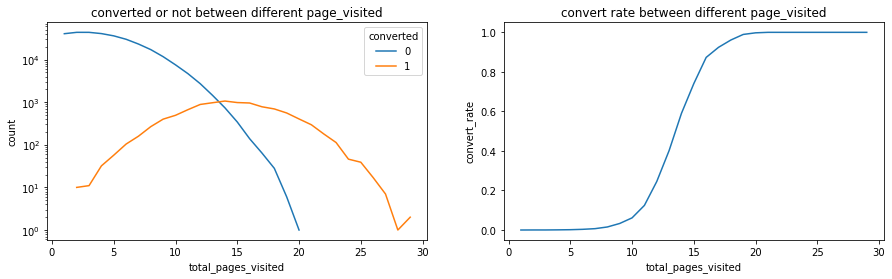

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex = True)

sns.lineplot(data = grouped_pages, x ='total_pages_visited', hue='converted', y = 'count', ax = ax[0])
ax[0].set_yscale("log")
ax[0].set_title('converted or not between different page_visited')

sns.lineplot(data = grouped_cr_pages, x ='total_pages_visited', y = 'convert_rate', ax = ax[1])
ax[1].set_title('convert rate between different page_visited')
plt.show()


## 模型訓練

In [36]:
## 使用One-Hot編碼將 'country','source'  轉換為數值。

dataset= df_clean_age.copy()
dataset=pd.get_dummies(dataset, columns=['country','source'], prefix=['country','source'])
dataset = dataset.reset_index()
dataset.columns

Index(['index', 'age', 'new_user', 'total_pages_visited', 'converted',
       'country_China', 'country_Germany', 'country_UK', 'country_US',
       'source_Ads', 'source_Direct', 'source_Seo'],
      dtype='object')

In [37]:
dataset.head()

,index,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,0,25,1,1,0,0,0,1,0,1,0,0
1,1,23,1,5,0,0,0,0,1,0,0,1
2,2,28,1,4,0,0,0,0,1,0,0,1
3,3,39,1,5,0,1,0,0,0,0,0,1
4,4,30,1,6,0,0,0,0,1,0,0,1


In [38]:
## 將資料集分成 training and  test
X_new = dataset[[ 'age', 'new_user', 'total_pages_visited', 
       'country_China', 'country_Germany', 'country_UK', 'country_US',
       'source_Ads', 'source_Direct', 'source_Seo']]
y_new = dataset['converted']

features = list(X_new.columns)

## 將資料分成 7:3 的 training 和 test

## 20221122 使用分層抽樣 (stratify) 參數來分割資料 , stratify=y_new
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, stratify=y_new) 


print(y_new.mean())
print(y_train.mean(),y_test.mean())
## 因為y_train.mean()和y_test.mean()都與y.mean()相似，我們可以說，拆分過程沒有導入任何偏差。

0.032435615827841976
0.0324342515155236 0.03243879922325152


## LogisticRegressionCV進行分類

In [39]:

'''
lrcv  = LogisticRegressionCV(Cs=np.logspace(-3,3,5) ,  dual=False, scoring='roc_auc',  
                              max_iter=1000, n_jobs=-1, verbose=1) 

'''
lrcv  = LogisticRegressionCV(Cs=np.logspace(-3,3,10) ,  dual=False, scoring='roc_auc',   
                              max_iter=1000, n_jobs=-1, verbose=1)
 


lrcv.fit(X_train,y_train)

lrcv.score(X_train,y_train)
lrcv.score(X_test,y_test)
y_test_predict = lrcv.predict(X_test)


## 預測成功的比例
print('訓練集: ',lrcv.score(X_train,y_train))
print('測試集: ',lrcv.score(X_test,y_test))
print(classification_report( y_test, y_test_predict))

## scikit-learn的LogisticRegressionCV說明 :   https://scikit-learn.org.cn/view/381.html
## Logistic回歸—LogisticRegressionCV實現參數優化: https://reurl.cc/lZDqLd
## scoring 各項指標說明 : https://blog.csdn.net/CherDW/article/details/55813071

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


訓練集:  0.9860766184575267
測試集:  0.9858936915931856
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91182
           1       0.85      0.68      0.76      3057

    accuracy                           0.99     94239
   macro avg       0.92      0.84      0.87     94239
weighted avg       0.98      0.99      0.98     94239




從LogisticRegressionCV的結果來看，
模型準確度0.85，但召回率只有0.68～0.7，意味者此模型將３０％～３２％的轉換用戶分類為非轉換用戶。

指標評估 :https://www.ycc.idv.tw/confusion-matrix.html

In [40]:
## 查看各特徵的重要性

'''
feat_importances = pd.DataFrame({"name":X_train.columns,"coef":lrcv.coef_[0]})
feat_importances = feat_importances[['name','coef']]# reorder the columns
feat_importances['importances'] = np.abs( feat_importances['coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances
'''
importances = abs(lrcv.coef_[0])
feat_importances = pd.Series(importances,index=features)
feat_importances.sort_values(ascending=False)


country_China          2.704957
new_user               1.719251
country_Germany        1.101842
country_UK             0.918462
total_pages_visited    0.762377
country_US             0.530908
source_Direct          0.178229
age                    0.072919
source_Ads             0.035454
source_Seo             0.010969
dtype: float64

## GradientBoostingClassifier進行分類

In [41]:
#建立梯度提升機
GBclf = GradientBoostingClassifier()

#特徵選擇
GBclf.fit(X_train,y_train)

y_pred =GBclf.predict(X_test)
fpr_xgb, tpr_xgb, _= roc_curve(y_test, y_pred)


## 預測成功的比例
print('訓練集: ',GBclf.score(X_train,y_train))
print('測試集: ',GBclf.score(X_test,y_test))
print('--------------- \n')
print('f1 score: ',f1_score(y_test, y_pred))
print('precision score: ',precision_score(y_test, y_pred))
print('recall score: ',recall_score(y_test, y_pred))

print("confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

訓練集:  0.9862113501689473
測試集:  0.9855792187947665
--------------- 

f1 score:  0.7531335149863759
precision score:  0.8468137254901961
recall score:  0.6781157998037292
confusion matrix: 
 [[90807   375]
 [  984  2073]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91182
           1       0.85      0.68      0.75      3057

    accuracy                           0.99     94239
   macro avg       0.92      0.84      0.87     94239
weighted avg       0.98      0.99      0.98     94239



In [42]:
## 查看各特徵的重要性
feats = pd.Series(data=GBclf.feature_importances_, index=features)
feats = feats.sort_values(ascending=False)
feats

total_pages_visited    0.863639
new_user               0.057561
country_China          0.054014
age                    0.022559
country_Germany        0.000683
country_US             0.000575
country_UK             0.000429
source_Direct          0.000301
source_Ads             0.000210
source_Seo             0.000028
dtype: float64

## 針對樣本不平均的處理

In [43]:
#解決分類樣本數量不平衡的狀況的套件
from imblearn.over_sampling import SMOTE
#將訓練資料集透過 SMOTE 技術，將不平衡的 converted 調整為 0 : 1  = 1:1  
'''
sm = SMOTE(random_state=4)
train_data,train_Y_res = sm.fit_sample(df_train, train_Y.ravel())
train_data_res = pd.DataFrame(train_data_res,columns=df_train.columns)
'''
sm = SMOTE(random_state=4)
X_train, y_train = sm.fit_sample(X_train, y_train)

unique, counts = np.unique(y_train, return_counts=True)
print("balanced training data: ", unique, counts)

Using TensorFlow backend.
W1123 13:09:04.887025 28992 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


balanced training data:  [0 1] [212759 212759]


In [44]:
lrcv  = LogisticRegressionCV(Cs=np.logspace(-3,3,10) ,  dual=False, scoring='roc_auc',   
                              max_iter=1000, n_jobs=-1, verbose=1)
 


lrcv.fit(X_train,y_train)

lrcv.score(X_train,y_train)
lrcv.score(X_test,y_test)
y_test_predict = lrcv.predict(X_test)


## 預測成功的比例
print('訓練集: ',lrcv.score(X_train,y_train))
print('測試集: ',lrcv.score(X_test,y_test))
print(classification_report( y_test, y_test_predict))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.6s finished


訓練集:  0.9916288836578374
測試集:  0.9850881728941114
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     91182
           1       0.39      0.92      0.55      3057

    accuracy                           0.95     94239
   macro avg       0.70      0.94      0.76     94239
weighted avg       0.98      0.95      0.96     94239



In [45]:
## 查看各特徵的重要性
importances = abs(lrcv.coef_[0])
feat_importances = pd.Series(importances,index=features)
feat_importances.sort_values(ascending=False)


country_China          15.183342
source_Direct          10.843454
source_Ads             10.526161
country_Germany        10.403415
source_Seo             10.391466
country_US              9.895072
country_UK              9.859488
new_user                2.382790
total_pages_visited     0.816352
age                     0.093207
dtype: float64

In [46]:
#建立梯度提升機
GBclf = GradientBoostingClassifier()

#特徵選擇
GBclf.fit(X_train,y_train)

y_pred =GBclf.predict(X_test)
fpr_xgb, tpr_xgb, _= roc_curve(y_test, y_pred)


## 預測成功的比例
print('訓練集: ',GBclf.score(X_train,y_train))
print('測試集: ',GBclf.score(X_test,y_test))
print('--------------- \n')
print('f1 score: ',f1_score(y_test, y_pred))
print('precision score: ',precision_score(y_test, y_pred))
print('recall score: ',recall_score(y_test, y_pred))

print("confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

訓練集:  0.9505473328977858
測試集:  0.9477817039654496
--------------- 

f1 score:  0.5347452018530774
precision score:  0.376063829787234
recall score:  0.9250899574746484
confusion matrix: 
 [[86490  4692]
 [  229  2828]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     91182
           1       0.38      0.93      0.53      3057

    accuracy                           0.95     94239
   macro avg       0.69      0.94      0.75     94239
weighted avg       0.98      0.95      0.96     94239



In [47]:
## 查看各特徵的重要性
feats = pd.Series(data=GBclf.feature_importances_, index=features)
feats = feats.sort_values(ascending=False)
feats

total_pages_visited    0.904585
new_user               0.043647
country_China          0.040120
age                    0.005513
source_Ads             0.003779
country_US             0.000942
country_UK             0.000528
source_Direct          0.000413
country_Germany        0.000303
source_Seo             0.000171
dtype: float64

Precision和Recall同時關注的都是True Positive（都在分子），但是角度不一樣，Precision看的是在預測正向的情形下，實際的「精準度」是多少，而Recall則是看在實際情形為正向的狀況下，預測「能召回多少」實際正向的答案。(引用 如何辨別機器學習模型的好壞？秒懂Confusion Matrix)

這意味著數據團隊要去衡量跟注意要用什麼指標去看,例如模型準確率跟Recall或其他指標。調整數據平衡就會導致模型準確度降低。

## 結論與建議

1. 客戶主要來自美國，但他們的轉化率並不是第一。推測我們的網站很可能來自美國，這裡的人們可能有很多選擇。來自德國的顧客最少，但轉化率最高。轉換率高，建議團隊可以針對德國人去做行銷，吸引更多的德國人。


2. 2/3的瀏覽者是新客戶,其餘為回頭客,而回頭客的轉換率是新顧客的近5倍(0.0724 : 0.0141)。因此,留住老客戶非常重要。這邊會需要關注 [客戶留存率]與[客戶流失率]。


3. total_pages_visited是影響整個轉換率(或模型)最重要的特徵，這意味著用戶瀏覽我們網站的時間越長，轉化並下單的可能性就越大。但也還是存在著有顧客的total_pages_visited很高(>15),但卻沒下單的情況。推測對方應該還是有很高度的購買意願,因此可以透過email向對方發送提醒或促銷(例如:還有商品在購物車的通知信)。也可以去分析影響這些族群的下單因素(EX:價格或是商品評論 etc.)。


4. 被廣告（Ads）吸引的用戶的平均轉化率最高，這意味著我們廣告系統是否能夠精准定位潛在客戶，那麼轉換率會提高很多。





In [48]:
## 參考
## 1. https://github.com/stasi009/TakeHomeDataChallenges
## 2. https://github.com/dongzhang84/data_challenges
## 3.